Epoch [1/20], Train Loss: 3.6811, Train MAE: 1.6956, Train R²: -3.6620, Validation Loss: 3.3520, Validation MAE: 1.5975, Validation R²: -3.2154
Epoch [2/20], Train Loss: 3.1661, Train MAE: 1.5478, Train R²: -3.0037, Validation Loss: 2.8405, Validation MAE: 1.4429, Validation R²: -2.5661
Epoch [3/20], Train Loss: 2.6430, Train MAE: 1.3886, Train R²: -2.3848, Validation Loss: 2.2918, Validation MAE: 1.2693, Validation R²: -1.8697
Epoch [4/20], Train Loss: 2.0822, Train MAE: 1.2057, Train R²: -1.6203, Validation Loss: 1.7320, Validation MAE: 1.0792, Validation R²: -1.1605
Epoch [5/20], Train Loss: 1.5488, Train MAE: 1.0249, Train R²: -0.9530, Validation Loss: 1.2510, Validation MAE: 0.9079, Validation R²: -0.5528
Epoch [6/20], Train Loss: 1.1153, Train MAE: 0.8697, Train R²: -0.4083, Validation Loss: 0.8937, Validation MAE: 0.7720, Validation R²: -0.1039
Epoch [7/20], Train Loss: 0.8100, Train MAE: 0.7517, Train R²: -0.0116, Validation Loss: 0.6650, Validation MAE: 0.6735, Validation R²: 

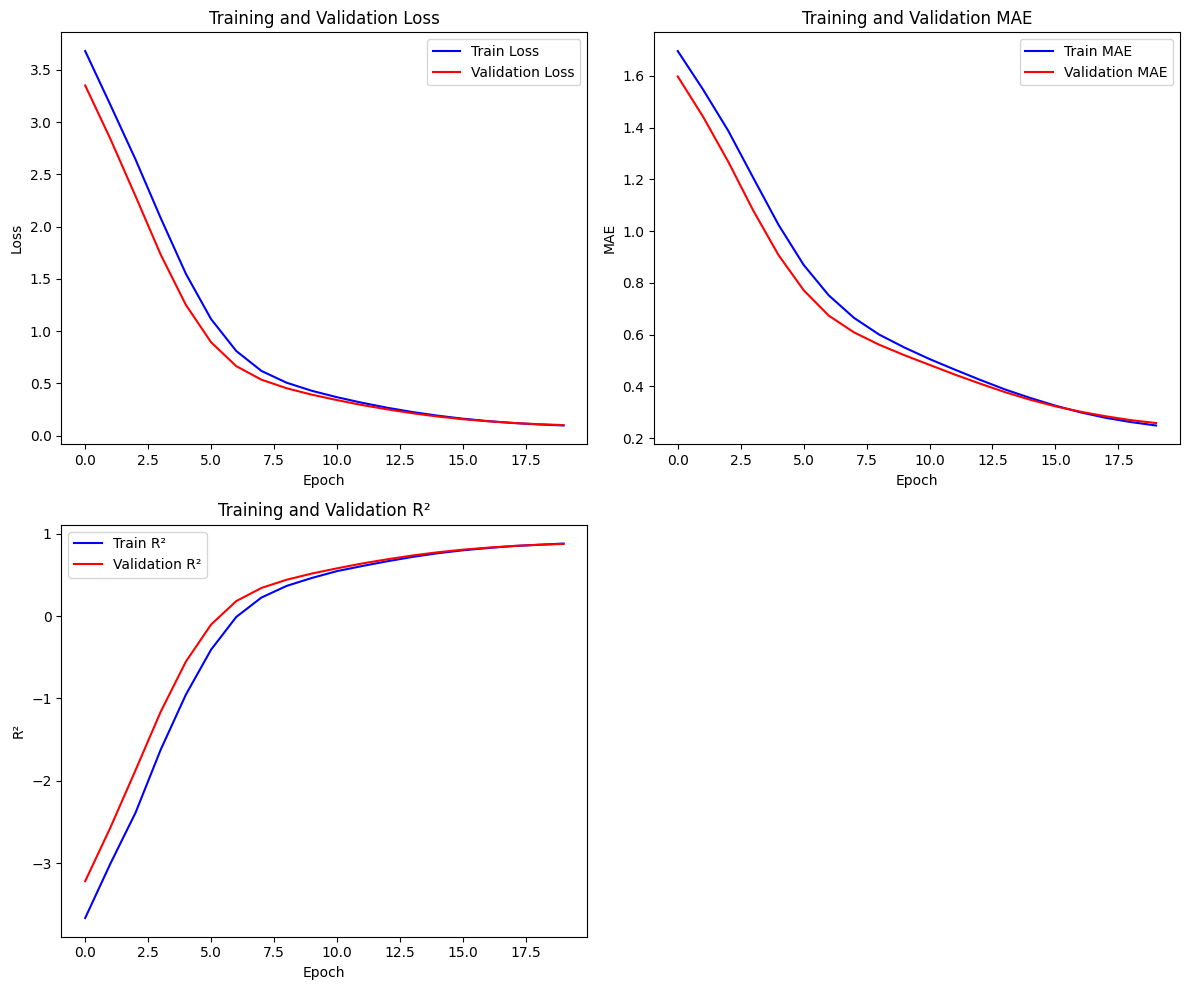

In [11]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("data.csv")

# Drop the unnecessary columns
df = df.drop(columns=['StudentID', 'GradeClass'])

# Separate features from target
X = df.drop(columns=["GPA"])  # Features
y = df['GPA']  # Target

# Normalize the columns of the dataset
scaler = StandardScaler()  # Mean = 0, Standard Deviation = 1
X_scaled = scaler.fit_transform(X)  # Fit the scaler to the features and transform them

# Convert to tensors for use with PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Convert features to tensor
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Convert target to tensor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=123)

# Create DataLoader objects for training and testing data
train_data = TensorDataset(X_train, y_train)  # Pair features and target
test_data = TensorDataset(X_test, y_test)  # Pair features and target

# DataLoader objects are used to automatically create batches of data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the neural network architecture
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First hidden layer with 64 neurons
        self.fc2 = nn.Linear(64, 32)  # Second hidden layer with 32 neurons
        self.fc3 = nn.Linear(32, 1)  # Output layer (predict GPA)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # Output layer (no activation, since we're predicting a continuous value)
        return x

# Initialize the model with the number of features
model = MLP(input_dim=X_train.shape[1])

# Define the loss function
loss_fn = nn.MSELoss()  # Mean Squared Error for regression

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize lists to store losses for plotting
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_mae = 0.0
    running_r2 = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = loss_fn(outputs, y_batch)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * X_batch.size(0)
        
        # Calculate MAE and R²
        mae = mean_absolute_error(y_batch.detach().numpy(), outputs.detach().numpy())
        r2 = r2_score(y_batch.detach().numpy(), outputs.detach().numpy())
        running_mae += mae * X_batch.size(0)
        running_r2 += r2 * X_batch.size(0)
    
    # Average training loss
    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_train_mae = running_mae / len(train_loader.dataset)
    avg_train_r2 = running_r2 / len(train_loader.dataset)
    
    # Now calculate validation loss
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    running_val_mae = 0.0
    running_val_r2 = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in test_loader:
            val_outputs = model(X_val_batch)  # Forward pass
            val_loss = loss_fn(val_outputs, y_val_batch)  # Compute the validation loss
            running_val_loss += val_loss.item() * X_val_batch.size(0)
            
            # Calculate MAE and R² for validation
            val_mae = mean_absolute_error(y_val_batch.detach().numpy(), val_outputs.detach().numpy())
            val_r2 = r2_score(y_val_batch.detach().numpy(), val_outputs.detach().numpy())
            running_val_mae += val_mae * X_val_batch.size(0)
            running_val_r2 += val_r2 * X_val_batch.size(0)
    
    # Average validation loss
    avg_val_loss = running_val_loss / len(test_loader.dataset)
    avg_val_mae = running_val_mae / len(test_loader.dataset)
    avg_val_r2 = running_val_r2 / len(test_loader.dataset)
    
    # Print both training and validation losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Train MAE: {avg_train_mae:.4f}, Train R²: {avg_train_r2:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation MAE: {avg_val_mae:.4f}, "
          f"Validation R²: {avg_val_r2:.4f}")
    
    # Store the metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)
    train_r2s.append(avg_train_r2)
    val_r2s.append(avg_val_r2)

# Plot loss curves
plt.figure(figsize=(12, 10))

# Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation MAE
plt.subplot(2, 2, 2)
plt.plot(range(num_epochs), train_maes, label='Train MAE', color='blue')
plt.plot(range(num_epochs), val_maes, label='Validation MAE', color='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

# Training and Validation R²
plt.subplot(2, 2, 3)
plt.plot(range(num_epochs), train_r2s, label='Train R²', color='blue')
plt.plot(range(num_epochs), val_r2s, label='Validation R²', color='red')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training and Validation R²')
plt.legend()

plt.tight_layout()
plt.show()
